In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from tqdm.notebook import tqdm

In [26]:
BASE = '../input/'

In [43]:
df_census = pd.read_csv(BASE + 'census_starter.csv')
df_train = pd.read_csv(BASE + 'train.csv')
df_test = pd.read_csv(BASE + 'test.csv')

In [44]:
df_train['istest'] = 0
df_test['istest'] = 1
df_raw = pd.concat((df_train, df_test)).sort_values(['cfips','row_id']).reset_index(drop=True)

In [45]:
df_raw['first_day_of_month'] = pd.to_datetime(df_raw["first_day_of_month"])
df_raw['county'] = df_raw.groupby('cfips')['county'].ffill()
df_raw['state'] = df_raw.groupby('cfips')['state'].ffill()
df_raw["year"] = df_raw["first_day_of_month"].dt.year
df_raw["month"] = df_raw["first_day_of_month"].dt.month
df_raw["dcount"] = df_raw.groupby(['cfips'])['row_id'].cumcount()
df_raw['county_i'] = (df_raw['county'] + df_raw['state']).factorize()[0]
df_raw['state_i'] = df_raw['state'].factorize()[0]

In [46]:
df_raw.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0


In [47]:
lag = 1

df_raw[f'mbd_lag_{lag}'] = df_raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()

<AxesSubplot:xlabel='dcount'>

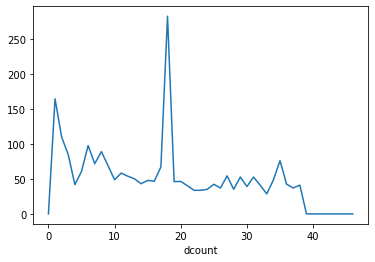

In [48]:
df_raw['dif'] = (df_raw['microbusiness_density'] / df_raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
df_raw.loc[(df_raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
df_raw.loc[(df_raw[f'microbusiness_density']>0) & (df_raw[f'mbd_lag_{lag}']==0), 'dif'] = 1 
df_raw['dif'] = df_raw['dif'].abs()
df_raw.groupby('dcount')['dif'].sum().plot()

In [50]:
outliers = []
cnt = 0
for o in tqdm(df_raw.cfips.unique()):
    indices = (df_raw['cfips']==o)
    tmp = df_raw.loc[indices].copy().reset_index(drop=True)
    var = tmp.microbusiness_density.values.copy()
    #vmax = np.max(var[:38]) - np.min(var[:38])
    
    for i in range(37, 2, -1):
        thr = 0.20*np.mean(var[:i])
        difa = abs(var[i]-var[i-1])
        if (difa>=thr):
            var[:i] *= (var[i]/var[i-1])
            outliers.append(o)
            cnt+=1
    var[0] = var[1]*0.99
    df_raw.loc[indices, 'microbusiness_density'] = var
    
outliers = np.unique(outliers)
len(outliers), cnt

  0%|          | 0/3135 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


(481, 732)

<AxesSubplot:xlabel='dcount'>

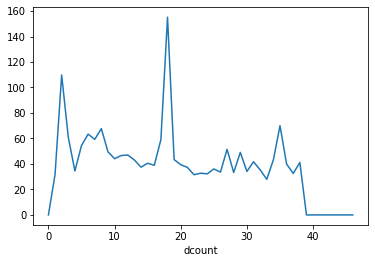

In [35]:
lag = 1
df_raw[f'mbd_lag_{lag}'] = df_raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
df_raw['dif'] = (df_raw['microbusiness_density'] / df_raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
df_raw.loc[(df_raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
df_raw.loc[(df_raw[f'microbusiness_density']>0) & (df_raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
df_raw['dif'] = df_raw['dif'].abs()
df_raw.groupby('dcount')['dif'].sum().plot()

In [36]:
outliers

array([ 1013,  1035,  1037,  1045,  1057,  1059,  1085,  1111,  1125,
        1131,  1133,  2060,  2070,  2100,  2164,  2188,  2282,  5011,
        5029,  5031,  5049,  5061,  5065,  5077,  5079,  5081,  5091,
        5093,  5113,  5141,  6005,  6015,  8011,  8014,  8031,  8047,
        8055,  8057,  8069,  8079,  8081,  8105,  8121, 10003, 10005,
       12001, 12013, 12029, 12037, 12045, 12051, 12065, 12077, 12107,
       12131, 13007, 13019, 13025, 13033, 13037, 13061, 13087, 13101,
       13119, 13131, 13149, 13169, 13193, 13239, 13243, 13251, 13287,
       13291, 13301, 13307, 13317, 15005, 16009, 16021, 16025, 16033,
       16037, 16045, 16049, 16051, 16077, 16079, 17013, 17037, 17063,
       17065, 17075, 17105, 17109, 17127, 17147, 17175, 17191, 18017,
       18025, 18031, 18039, 18041, 18049, 18073, 18083, 18087, 18103,
       18143, 18145, 18153, 18171, 19001, 19003, 19005, 19033, 19037,
       19051, 19063, 19065, 19067, 19071, 19125, 19129, 19133, 19143,
       19165, 19175,